# CNN with original data

In [1]:
import numpy as np
import pandas as pd

In [2]:
combined_df = pd.read_csv('../datasets/combined_df.csv')

In [3]:
from sklearn.model_selection import train_test_split

X = combined_df.drop(['subreddit', 'post'],  axis=1)  # Features
y = combined_df['subreddit']  # Target

In [4]:
# Print count of each class
print(y.value_counts())

subreddit
depression       117331
suicidewatch      66161
anxiety           57671
adhd              45631
bpd               24294
lonely            23635
autism             8869
schizophrenia      8712
ptsd               8643
addiction          7641
alcoholism         5911
Name: count, dtype: int64


In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X  , y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [6]:

# Convert X_train and X_test to numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val = np.array(X_val)

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping 

# Step 1: Encode the categorical target variable (y_train) using OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_val_encoded = encoder.transform(y_val.values.reshape(-1, 1))

# Step 2: Flatten the encoded labels
y_train_encoded = y_train_encoded.argmax(axis=1)
y_val_encoded = y_val_encoded.argmax(axis=1)
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1)).argmax(axis=1)
y_train_encoded = to_categorical(y_train_encoded) 
y_val_encoded = to_categorical(y_val_encoded) 


## Compiling and training the model

In [8]:
import os
os.environ['WANDB_NOTEBOOK_NAME'] = 'CNN_base.ipynb'

In [9]:
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import accuracy_score
import numpy as np

wandb.init(project='Reddit_mental_CNN_aayush')

# Your data: X_train, X_val, X_test, y_train_encoded, y_val_encoded, y_test_encoded

# Manual specification of parameters for the first run
params = {
    'filters': 16, 'kernel_size': 3, 'pool_size': 2, 'dense_units': 200, 'act': 'tanh'
}

wandb: Currently logged in as: aayushach16 (boys69). Use `wandb login --relogin` to force relogin


In [10]:
class CustomSaver(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 3 or epoch == 6:  # or save after some epoch, each k-th epoch etc.
            self.model.save("model_relu_{}.hd5".format(epoch))

In [11]:
import tensorflow as tf
model = Sequential()
model.add(Conv1D(filters=params['filters'], kernel_size=params['kernel_size'], activation=params['act'],
                 input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=params['pool_size']))
model.add(Flatten())
model.add(Dense(params['dense_units'], activation=params['act']))
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.00005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val_reshaped = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

saver = CustomSaver()

history = model.fit(X_train_reshaped, y_train_encoded, epochs=15, batch_size=16,
                    validation_data=(X_val_reshaped, y_val_encoded),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                               WandbCallback(), saver])

X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test_encoded, y_pred_classes)

wandb.log({'test_accuracy': accuracy})
wandb.log({'validation_loss': history.history['val_loss'][len(history.history['val_loss']) - 1], 'epoch': len(history.history['val_loss'])})

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/15
14040/14044 [============================>.] - ETA: 0s - loss: 1.1819 - accuracy: 0.5885

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best)... Done. 0.2s


14044/14044 [==============================] - 56s 4ms/step - loss: 1.1818 - accuracy: 0.5885 - val_loss: 1.0586 - val_accuracy: 0.6293
Epoch 2/15
14039/14044 [============================>.] - ETA: 0s - loss: 1.0205 - accuracy: 0.6398

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best)... Done. 0.0s


14044/14044 [==============================] - 62s 4ms/step - loss: 1.0205 - accuracy: 0.6398 - val_loss: 1.0151 - val_accuracy: 0.6384
Epoch 3/15
14033/14044 [============================>.] - ETA: 0s - loss: 0.9939 - accuracy: 0.6482

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best)... Done. 0.0s


14044/14044 [==============================] - 51s 4ms/step - loss: 0.9939 - accuracy: 0.6482 - val_loss: 0.9864 - val_accuracy: 0.6474
Epoch 4/15
14034/14044 [============================>.] - ETA: 0s - loss: 0.9775 - accuracy: 0.6534

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: model_relu_3.hd5/assets


INFO:tensorflow:Assets written to: model_relu_3.hd5/assets


14044/14044 [==============================] - 72s 5ms/step - loss: 0.9775 - accuracy: 0.6534 - val_loss: 0.9791 - val_accuracy: 0.6523
Epoch 5/15
14044/14044 [==============================] - 71s 5ms/step - loss: 0.9652 - accuracy: 0.6564 - val_loss: 1.0004 - val_accuracy: 0.6444
Epoch 6/15
14033/14044 [============================>.] - ETA: 0s - loss: 0.9556 - accuracy: 0.6597

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best)... Done. 0.0s


14044/14044 [==============================] - 66s 5ms/step - loss: 0.9557 - accuracy: 0.6597 - val_loss: 0.9725 - val_accuracy: 0.6546
Epoch 7/15
14041/14044 [============================>.] - ETA: 0s - loss: 0.9468 - accuracy: 0.6631

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best)... Done. 0.0s


INFO:tensorflow:Assets written to: model_relu_6.hd5/assets


INFO:tensorflow:Assets written to: model_relu_6.hd5/assets


14044/14044 [==============================] - 65s 5ms/step - loss: 0.9468 - accuracy: 0.6631 - val_loss: 0.9641 - val_accuracy: 0.6530
Epoch 8/15
14039/14044 [============================>.] - ETA: 0s - loss: 0.9385 - accuracy: 0.6642

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best)... Done. 0.0s


14044/14044 [==============================] - 66s 5ms/step - loss: 0.9385 - accuracy: 0.6642 - val_loss: 0.9560 - val_accuracy: 0.6554
Epoch 9/15
14041/14044 [============================>.] - ETA: 0s - loss: 0.9322 - accuracy: 0.6665

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best)... Done. 0.0s


14044/14044 [==============================] - 70s 5ms/step - loss: 0.9321 - accuracy: 0.6665 - val_loss: 0.9499 - val_accuracy: 0.6600
Epoch 10/15
14044/14044 [==============================] - 59s 4ms/step - loss: 0.9252 - accuracy: 0.6679 - val_loss: 0.9522 - val_accuracy: 0.6594
Epoch 11/15
14037/14044 [============================>.] - ETA: 0s - loss: 0.9195 - accuracy: 0.6704

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best)... Done. 0.0s


14044/14044 [==============================] - 66s 5ms/step - loss: 0.9195 - accuracy: 0.6704 - val_loss: 0.9483 - val_accuracy: 0.6609
Epoch 12/15
14044/14044 [==============================] - 66s 5ms/step - loss: 0.9131 - accuracy: 0.6725 - val_loss: 0.9545 - val_accuracy: 0.6567
Epoch 13/15
14038/14044 [============================>.] - ETA: 0s - loss: 0.9074 - accuracy: 0.6740

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best)... Done. 0.0s


14044/14044 [==============================] - 66s 5ms/step - loss: 0.9074 - accuracy: 0.6740 - val_loss: 0.9436 - val_accuracy: 0.6597
Epoch 14/15
14044/14044 [==============================] - 66s 5ms/step - loss: 0.9016 - accuracy: 0.6762 - val_loss: 0.9546 - val_accuracy: 0.6562
Epoch 15/15
14035/14044 [============================>.] - ETA: 0s - loss: 0.8957 - accuracy: 0.6777

/Users/yeetusonthefetus/iiit/SMAI/project-boys/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best/assets
wandb: Adding directory to artifact (/Users/yeetusonthefetus/iiit/SMAI/project-boys/CNN/wandb/run-20231127_212001-xriopubo/files/model-best)... Done. 0.0s


2341/2341 [==============================] - 2s 723us/step


## Results of the model

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred_classes)
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_classes))

Accuracy: 0.6685378241112002
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.73      0.79     23566
           1       0.74      0.73      0.73     23355
           2       0.83      0.85      0.84     23341
           3       0.69      0.72      0.71     23431
           4       0.55      0.72      0.62     23377
           5       0.79      0.55      0.65     23453
           6       0.57      0.32      0.41     23301
           7       0.66      0.69      0.68     23667
           8       0.80      0.69      0.74     23555
           9       0.49      0.64      0.55     23666
          10       0.55      0.71      0.62     23417

    accuracy                           0.67    258129
   macro avg       0.68      0.67      0.67    258129
weighted avg       0.68      0.67      0.67    258129



In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Compute confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred_classes)


Python(97273) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Python(97274) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


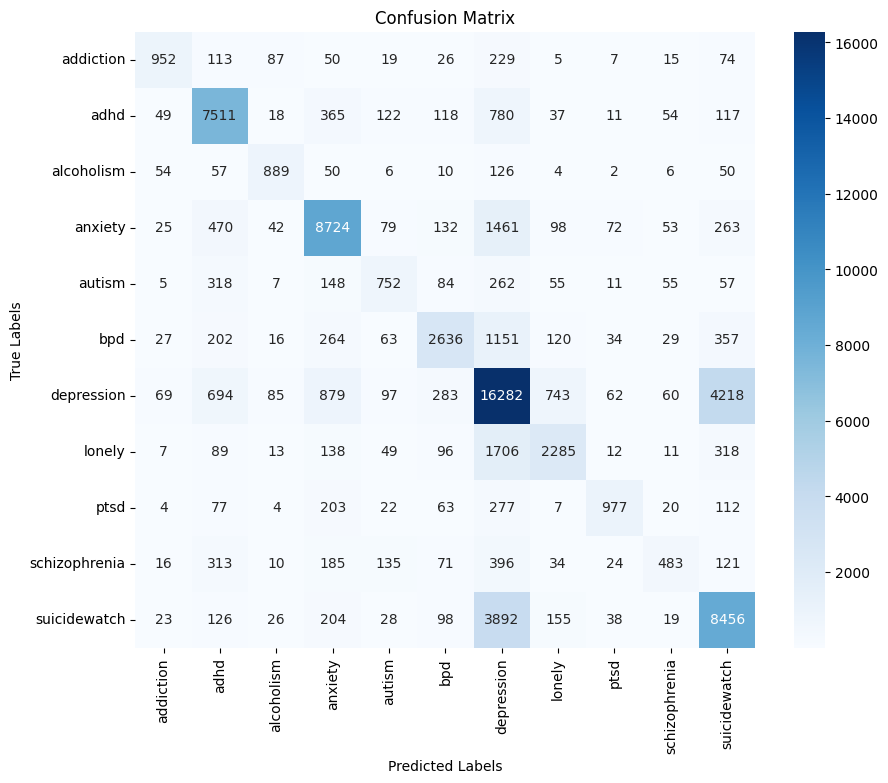

In [13]:

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
del model